# Importación de las librerias y carga de archivo STL

In [1]:
import numpy as np
import trimesh
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pyvista as pv

In [2]:
stl = int(1)  # Seleccionar el archivo STL a usar

# Diccionario con las rutas de los archivos STL
stl_paths = {
    # Gombocs
    1: r"C:\Users\david\Material Universidad\Retos\STL\Monostatic_Body_Release.STL", # Gomboc 1 con resolucion media
    2: r"C:\Users\david\Material Universidad\Retos\STL\GollyPoly.stl", # Gomboc 2 con resolucion alta
    # Archivos para confirmar el funcionamiento del algoritmo
    3: r"C:\Users\david\Material Universidad\Retos\STL\20000_polygon_sphere_100mm.STL", # Esfera
    4: r"C:\Users\David\Material Universidad\Retos\STL\Cilindro_3D.stl", # Cilindro
    5: r"C:\Users\David\Material Universidad\Retos\STL\Cubo_Prueba_20x20.stl", # Cubo
    }

# Usar el archivo correspondiente dependiendo de prueba
mesh = trimesh.load_mesh(stl_paths[stl])

# Calculo del Tensor de Inercia diagonalizado y los ejes principales de inercia

In [3]:
# Calcular el centro de masa y el tensor de inercia
centroid = mesh.center_mass
# (Opcional) avisar si la malla no es hermética
if not mesh.is_watertight:
    print("⚠️ Atención: la malla no es hermética — los resultados pueden no ser fiables.")

# 1) Tensor de inercia con respecto al CM, alineado en ejes globales
I_cm = mesh.moment_inertia
# 📖 mesh.moment_inertia ya está centrado en el centro de masa y alineado con ejes cartesianos :contentReference[oaicite:0]{index=0}

# 2) Momentos principales de inercia (vector diagonal)
principal_moments = mesh.principal_inertia_components
# 📖 moment principal order corresponde a mesh.principal_inertia_vectors :contentReference[oaicite:1]{index=1}

# 3) Ejes principales de rotación (vectores propios)
principal_axes = mesh.principal_inertia_vectors
# 📖 devuelve tres vectores unitarios ordenados según principal_inertia_components :contentReference[oaicite:2]{index=2}

# Resultados
print("Tensor de inercia (centro de masa, no desplazado):\n", I_cm)
print("Momentos principales de inercia:", principal_moments)
print("Ejes principales (columnas):\n", principal_axes)

# Verificación rápida: principal_axes^T · I_cm · principal_axes debe ser diagonal
I_diag_check = principal_axes.T @ I_cm @ principal_axes
print("I_alineado con ejes principales (debe ser diagonal):\n", I_diag_check)

Tensor de inercia (centro de masa, no desplazado):
 [[ 2.49016695e+07 -6.47109938e+01 -2.47881575e+01]
 [-6.47109938e+01  2.90053962e+07  1.56640829e+01]
 [-2.47881575e+01  1.56640829e+01  3.04345256e+07]]
Momentos principales de inercia: [24901669.53172833 29005396.24250979 30434525.59219955]
Ejes principales (columnas):
 [[ 1.00000000e+00  1.57688190e-05  4.48012928e-06]
 [-1.57687699e-05  1.00000000e+00 -1.09608509e-05]
 [-4.48030212e-06  1.09607803e-05  1.00000000e+00]]
I_alineado con ejes principales (debe ser diagonal):
 [[ 2.49016695e+07 -1.29422329e+02 -4.95758526e+01]
 [-1.29422329e+02  2.90053962e+07  3.13274850e+01]
 [-4.95758526e+01  3.13274850e+01  3.04345256e+07]]


# Grafica de la malla y los eigenvectors o vectores principales de rotación

c:\Users\david\miniforge3\envs\rigid_bodies\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


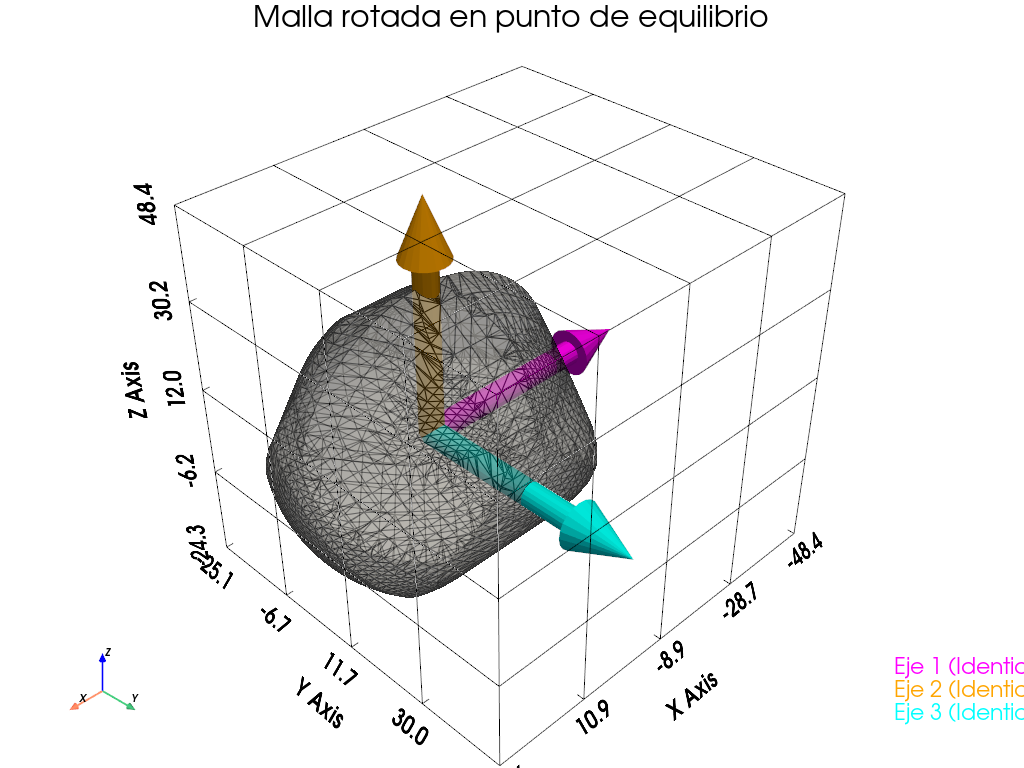

vectores propios rotados:
 [[-1.00000000e+00  4.48012928e-06  1.57688190e-05]
 [ 1.57687699e-05 -1.09608509e-05  1.00000000e+00]
 [ 4.48030212e-06  1.00000000e+00  1.09607803e-05]]


In [4]:
# Rotación y preparación de malla
rotation_matrix = np.array([[-1, 0, 0],
                            [ 0, 0, 1],
                            [ 0, 1, 0]])

# Rotar vértices
rotated_vertices = (mesh.vertices - centroid) @ rotation_matrix

# Crear malla en formato PyVista
faces_pv = np.hstack([[3] + list(face) for face in mesh.faces])  # Cada cara con 3 vértices
pv_mesh = pv.PolyData(rotated_vertices, faces_pv)

# Crear plotter
plotter = pv.Plotter()

# Añadir la malla rotada
plotter.add_mesh(pv_mesh, color='lightgray', show_edges=True, opacity=0.6)

# Rotar vectores propios
rotated_eigvecs = principal_axes @ rotation_matrix

# Dibujar flechas para los ejes de la matriz identidad
colors_identity = ['magenta', 'orange', 'cyan']
line_length = 0.5 * np.linalg.norm(pv_mesh.length)  # ajustar según el tamaño de la malla

for i in range(3):
    vec = rotated_eigvecs[:, i]
    arrow = pv.Arrow(start=(0, 0, 0), direction=vec, scale=line_length)
    plotter.add_mesh(arrow, color=colors_identity[i], label=f'Eje {i+1} (Identidad)')

# Configurar visualización
plotter.set_background('white')
plotter.add_axes()
plotter.show_bounds(grid='front', location='outer')

# Título más separado de la malla (arriba centrado)
plotter.add_text("Malla rotada en punto de equilibrio", position='upper_edge', font_size=12, color='black')

# Mostrar leyenda en parte inferior derecha
plotter.add_legend(
    labels=[
        ("Eje 1 (Identidad)", "magenta"),
        ("Eje 2 (Identidad)", "orange"),
        ("Eje 3 (Identidad)", "cyan"),
    ],
    bcolor='white',
    border=True,
    size=(0.2, 0.1),
    loc='lower right'
)

# Mostrar visualización
plotter.show()

# Mostrar vectores rotados por consola
print("vectores propios rotados:\n", rotated_eigvecs)

# Se definen los triangulos del archivo STL

In [5]:
# Obtener los vértices y caras de la malla
vertices = mesh.vertices
faces = mesh.faces

# Definicion de la posicion de los vertices de cada triangulo
V1 = vertices[faces[:, 0]]
V2 = vertices[faces[:, 1]]
V3 = vertices[faces[:, 2]]

# Calculo de los vectores normales a la superficie

In [6]:
# Producto cruzado de los lados del triángulo
normals = np.cross(V2 - V1, V3 - V1)

# Normalizar los vectores normales
normals /= np.linalg.norm(normals, axis=1, keepdims=True)

print(normals)

[[-0.32841567  0.77452338  0.5406077 ]
 [-0.42981643  0.72318684  0.5406095 ]
 [-0.4776886   0.69250267  0.54060489]
 ...
 [ 0.22626223  0.38399058 -0.89518525]
 [ 0.22626501  0.38399158 -0.89518412]
 [ 0.22626232  0.38399115 -0.89518499]]


# Calculo de los vectores desde el centro de masa a la superficie

In [7]:
midpoints = (V1 + V2 + V3) / 3  # Puntos medios de los triángulos

# Calcular los vectores desde el centro de masa a cada punto medio
vectors = midpoints - centroid

print(vectors)

[[ -9.69789385  21.89183013  12.24958442]
 [-12.12281044  20.59074879  12.24958442]
 [-13.55092374  19.64630604  12.24958442]
 ...
 [  6.35008232   8.63685576 -23.32095697]
 [  6.73496493   9.97851531 -22.64816898]
 [  7.05450941   9.97851531 -22.56740167]]


# Calculo de la altura del centro de masa

In [8]:
def altura_centro_masa(vectors, normals):
    """
    Calcula la proyección (producto punto) de cada vector sobre su correspondiente normal.
    Parámetros:
      vectors : np.ndarray de shape (N, 3)
          Vectores desde el centro de masa hasta los centros de los triángulos.
      normals : np.ndarray de shape (N, 3)
          Vectores normales (normalizados) de cada triángulo.
    Retorna:
      alturas : np.ndarray de shape (N,)
          Producto punto de cada par, que se interpretará como la "altura".
    """
    alturas = np.sum(vectors * normals, axis=1)
    return alturas

In [9]:
# Calculamos las alturas (proyecciones)
alturas = altura_centro_masa(vectors, normals)
print("Alturas (proyecciones del vector desde el centro de masa):\n", alturas)

Alturas (proyecciones del vector desde el centro de masa):
 [26.76289417 26.72378335 26.70042649 ... 25.62983181 25.62983403
 25.62983038]


# Parametrización de los vectores con respecto a theta y phi

In [10]:
def compute_theta_phi(vectors, rotation_matrix):
    """
    Calcula los ángulos theta y phi de cada vector usando las definiciones:
      theta = arccos(z / r)
      phi   = sgn(y) * arccos(x / sqrt(x^2 + y^2))
    donde (x, y, z) son las componentes del vector en el sistema de coordenadas (e1, e2, e3).
    
    Parámetros:
      vectors : np.ndarray de shape (N, 3)
          Vectores en coordenadas cartesianas (originales).
      eigvecs : np.ndarray de shape (3, 3)
          Matriz de eigenvectores, donde cada columna es un eigenvector.

    Retorna:
      theta : np.ndarray de shape (N,)
          Ángulo polar (definición de la imagen).
      phi   : np.ndarray de shape (N,)
          Ángulo azimutal (definición de la imagen).
    """
    
    # Para cada vector, calculamos sus componentes en el sistema (e1, e2, e3)
    #   x' = v · e1
    #   y' = v · e3
    #   z' = v · e2
    x_comp = np.dot(vectors, rotation_matrix[:, 0])  # Proyección en el eje "x"
    y_comp = np.dot(vectors, rotation_matrix[:, 1])  # Proyección en el eje "y"
    z_comp = np.dot(vectors, rotation_matrix[:, 2])  # Proyección en el eje "z"
    
    # Norma de cada vector en este nuevo sistema
    r = np.sqrt(x_comp**2 + y_comp**2 + z_comp**2)
    # Para evitar división por cero
    r_safe = np.where(r == 0, 1, r)
    
    # --------------------
    # Cálculo de theta
    # --------------------
    # theta = arccos(z / r)
    # Clipeamos el argumento de arccos a [-1,1] para evitar errores numéricos
    cos_theta = z_comp / r_safe
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.arccos(cos_theta)
    
    # --------------------
    # Cálculo de phi
    # --------------------
    # phi = sgn(y) * arccos(x / sqrt(x^2 + y^2))
    # Definimos el denominador para x^2 + y^2
    xy_norm = np.sqrt(x_comp**2 + y_comp**2)
    xy_norm_safe = np.where(xy_norm == 0, 1, xy_norm)  # evitar 0 en la división
    
    # arccos(x / sqrt(x^2 + y^2))
    arg_phi = x_comp / xy_norm_safe
    arg_phi = np.clip(arg_phi, -1.0, 1.0)  # clip para evitar fuera de dominio
    base_phi = np.arccos(arg_phi)
    
    # sgn(y)
    sgn_y = np.sign(y_comp)
    
    # Producto final
    phi = sgn_y * base_phi
    
    return theta, phi

In [11]:
# Parametrización
theta, phi = compute_theta_phi(vectors, rotation_matrix)
print("Theta:", min(theta), max(theta))
print("Phi:", min(phi), max(phi))

Theta: 0.032067506344798644 3.078754650498231
Phi: -3.1411962695538667 3.141592234498774


# Gráfica proporcional del potencial gravitacional

c:\Users\david\miniforge3\envs\rigid_bodies\Lib\site-packages\pyvista\plotting\renderer.py:1735: PyVistaDeprecationWarning: `xlabel` is deprecated. Use `xtitle` instead.
  warnings.warn(
c:\Users\david\miniforge3\envs\rigid_bodies\Lib\site-packages\pyvista\plotting\renderer.py:1741: PyVistaDeprecationWarning: `ylabel` is deprecated. Use `ytitle` instead.
  warnings.warn(
c:\Users\david\miniforge3\envs\rigid_bodies\Lib\site-packages\pyvista\plotting\renderer.py:1747: PyVistaDeprecationWarning: `zlabel` is deprecated. Use `ztitle` instead.
  warnings.warn(
c:\Users\david\miniforge3\envs\rigid_bodies\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


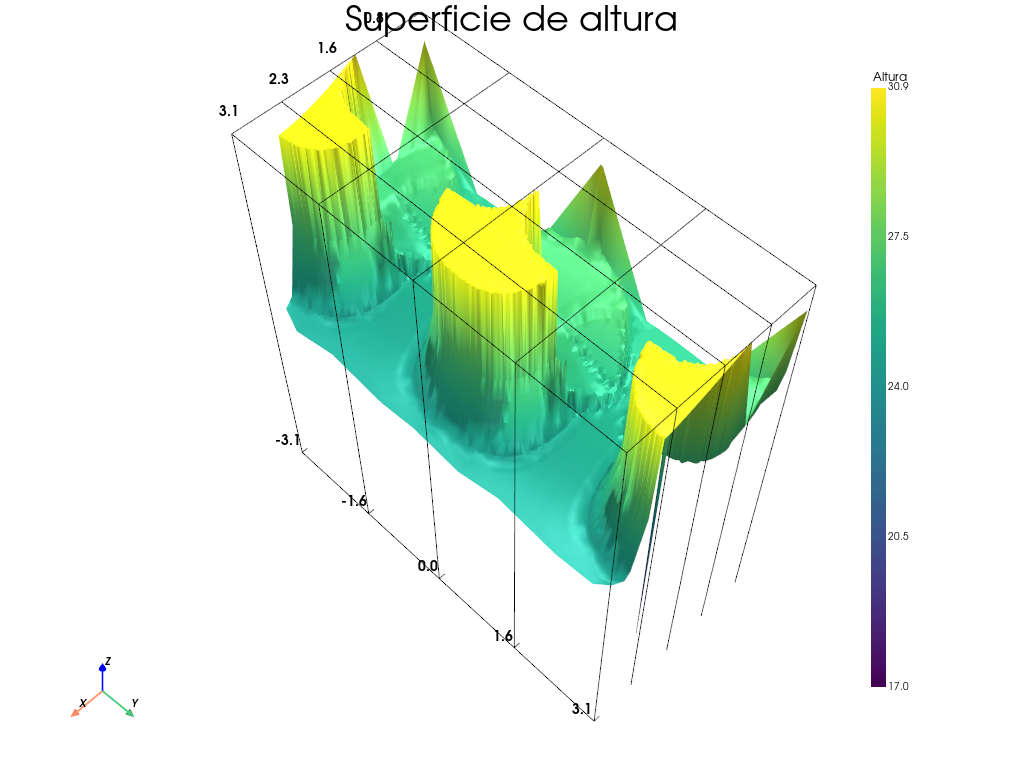

In [12]:
# Crear puntos 2D para la triangulación (θ, φ)
points_2d = np.column_stack((theta, phi))
cloud_2d = pv.PolyData(np.column_stack((theta, phi, np.zeros_like(theta))))  # plano 2D

# Generar superficie en 2D
surface = cloud_2d.delaunay_2d()

# Reemplazar Z con altura original
points_surface = surface.points
points_surface[:, 2] = alturas
surface.points = points_surface

# Configurar scalar bar en vertical (derecha)
scalar_bar_args = {
    "title": "Altura",
    "vertical": True,
    "position_x": 0.85,  # más a la derecha
    "position_y": 0.1,
    "width": 0.04,
    "height": 0.8,
    "title_font_size": 12,
    "label_font_size": 10
}

# Crear plotter
plotter = pv.Plotter()

plotter.add_mesh(
    surface,
    scalars=alturas,
    cmap='viridis',
    show_edges=False,
    smooth_shading=True,
    lighting=True,
    ambient=0.3,
    specular=0.4,
    specular_power=15,
    scalar_bar_args=scalar_bar_args
)

plotter.set_scale(1, 1, 0.5)
plotter.add_axes()
plotter.show_bounds(
    xlabel='θ',
    ylabel='φ',
    zlabel='Altura',
    grid='front',
    location='outer'
)

# Título en overlay
plotter.add_text("Superficie de altura", position="upper_edge", font_size=14)

plotter.show()
